<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>


**What?** PyTorch Lightning, ONNX Runtime



# Imports
<hr style="border:2px solid black"> </hr>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# Data Preprocessing
<hr style="border:2px solid black"> </hr>

We'll be using the credit card default dataset from UCI, we can download this dataset from [Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) as well.

There are many ways to implement the data preprocessing step, the high-level idea is to implement the following workflow:

- perform train/validation/test split.
- encode categorical columns as distinct numerical ids.
- standardize numerical columns.
- save the preprocesed data.

Here, we chose to preprocess the data once and save the output, so we won't have to go through these preprocessing steps every time. 

In [ ]:
input_path = './UCI_Credit_Card.csv'
df = pd.read_csv(input_path)
print(df.shape)
df.head()

In [ ]:
id_cols = ['ID']
cat_cols = ['EDUCATION', 'SEX', 'MARRIAGE']
num_cols = [
    'LIMIT_BAL', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]
label_col = 'default.payment.next.month'

print('number of categorical columns: ', len(cat_cols))
print('number of numerical columns: ', len(num_cols))

In [ ]:
test_size = 0.1
val_size = 0.3
random_state = 1234

df_train, df_test = train_test_split(
    df,
    test_size=test_size,
    random_state=random_state,
    stratify=df[label_col])

df_train, df_val = train_test_split(
    df_train,
    test_size=val_size,
    random_state=random_state,
    stratify=df_train[label_col])

print('train shape: ', df_train.shape)
print('validation shape: ', df_val.shape)
print('test shape: ', df_test.shape)

df_train.head()

In [ ]:
# store the category code mapping, so we can encode any new incoming data
# other than our training set
cat_code_dict = {}
for col in cat_cols:
    category_col = df_train[col].astype('category')
    cat_code_dict[col] = {value: idx for idx, value in enumerate(category_col.cat.categories)} 

cat_code_dict

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_train[num_cols])

In [ ]:
def preprocess(df, scaler, cat_code_dict, num_cols, cat_cols, label_col):
    df = df.copy()

    # numeric fields
    df[num_cols] = scaler.transform(df[num_cols])
    df[num_cols] = df[num_cols].astype(np.float32)

    # categorical fields
    for col in cat_cols:
        code_dict = cat_code_dict[col]
        code_fillna_value = len(code_dict)
        df[col] = df[col].map(code_dict).fillna(
            code_fillna_value).astype(np.int64)

    # label
    df[label_col] = df[label_col].astype(np.float32)
    return df

In [ ]:
df_groups = {
    'train': df_train,
    'val': df_val,
    'test': df_test
}

data_dir = 'onnx_data'
os.makedirs(data_dir, exist_ok=True)

for name, df_group in df_groups.items():
    filename = os.path.join(data_dir, f'{name}.csv')
    df_preprocessed = preprocess(df_group, scaler, cat_code_dict, num_cols, cat_cols, label_col)
    df_preprocessed.to_csv(filename, index=False)

df_preprocessed.dtypes

# PyTorch Dataset
<hr style="border:2px solid black"> </hr>

The next few code chunk involves understanding how to work with [Pytorch's Dataset and DataLoader](https://pytorch.org/docs/stable/data.html). We define a custom Dataset that allows us the load our preprocessed .csv file, and extract the numerical, categorical, and label columns.

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TabularDataset(Dataset):

    def __init__(self, path, num_cols, cat_cols, label_col):
        self.path = path
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.label_col = label_col
        self.df = read_data(path, num_cols, cat_cols, label_col)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        num_array = self.df[self.num_cols].iloc[idx].values
        cat_array = self.df[self.cat_cols].iloc[idx].values
        label_array = self.df[self.label_col].iloc[idx]
        return num_array, cat_array, label_array


def read_data(path, num_cols, cat_cols, label_col):
    float_cols = num_cols + [label_col]
    dtype = {col: np.float32 for col in float_cols}
    dtype.update({col: np.int64 for col in cat_cols})
    return pd.read_csv(path, dtype=dtype)

In [ ]:
batch_size = 2

path_train = os.path.join(data_dir, 'train.csv')
dataset = TabularDataset(path_train, num_cols, cat_cols, label_col)
data_loader = DataLoader(dataset, batch_size)

# our data loader now returns batches of numerical/categorical/label tensor
num_tensor, cat_tensor, label_tensor = next(iter(data_loader))

print('numerical value tensor:\n', num_tensor)
print('categorical value tensor:\n', cat_tensor)
print('label tensor:\n', label_tensor)

Note that one serious downside for this particular dataset implementation is it reads the entire data into memory, for large datasets, this might not be feasible. We'll leave out this enhancements for now.

# PyTorch Lightning Module
<hr style="border:2px solid black"> </hr>


- PyTorch Lightning is built on top of ordinary (vanilla) PyTorch. The purpose of Lightning is to provide a research framework that allows for fast experimentation and scalability, which it achieves via an OOP approach that removes boilerplate and hardware-reference code. This approach yields a litany of benefits.

- It is particularly useful when it comes to simplifying the achitecture; in particular you do not have to manually write the training loop.
    


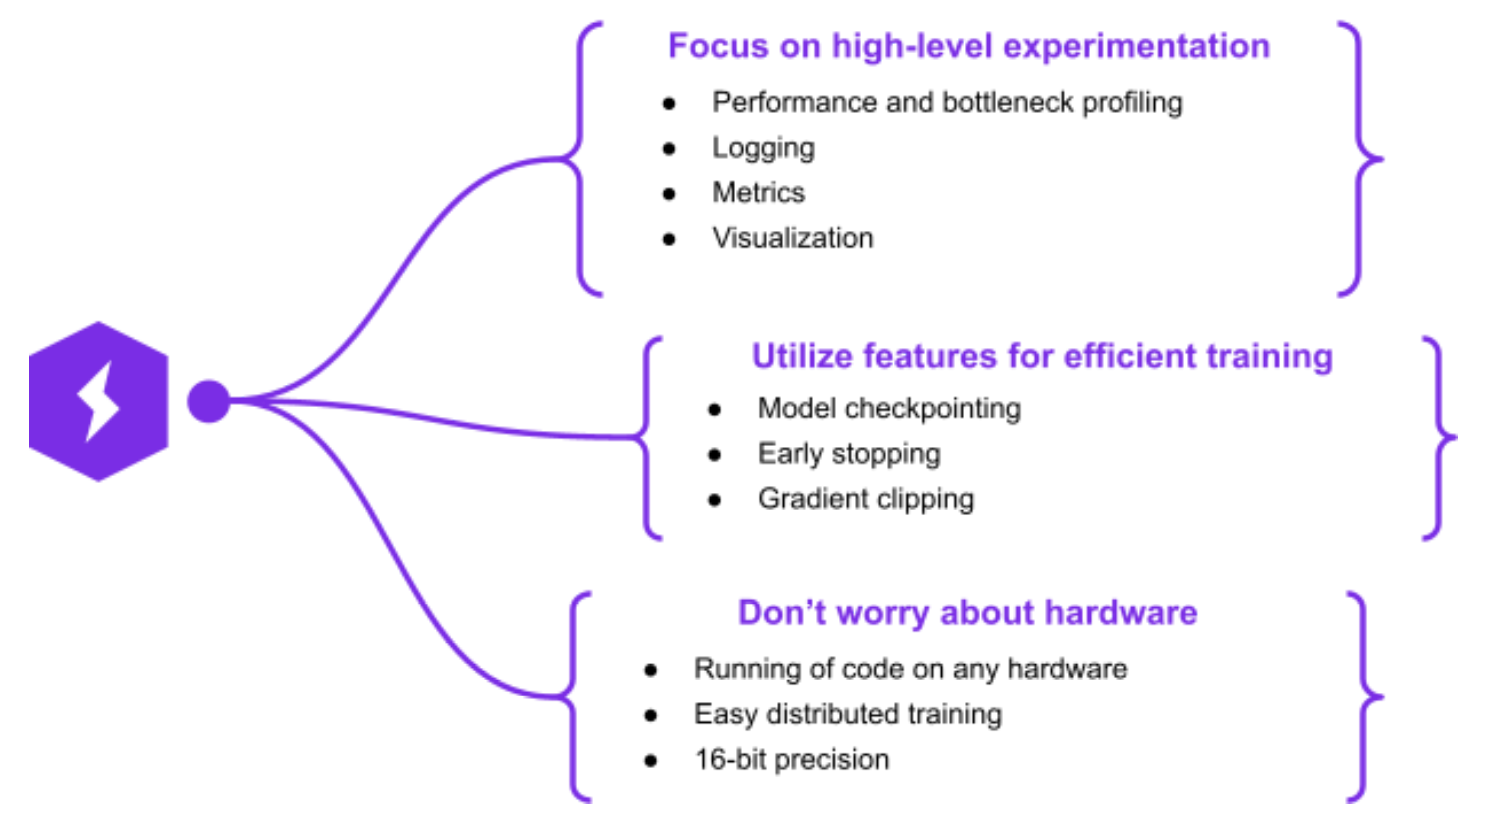

In [ ]:
class TabularDataModule(pl.LightningDataModule):

    def __init__(self, data_dir, num_cols, cat_cols, label_col, num_workers=2,
                 batch_size_train=128, batch_size_val=64, batch_size_test=512):
        super().__init__()
        self.data_dir = data_dir
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.label_col = label_col
        self.num_workers = num_workers
        self.batch_size_train = batch_size_train
        self.batch_size_val = batch_size_val
        self.batch_size_test = batch_size_test

    def setup(self, stage):
        num_cols = self.num_cols
        cat_cols = self.cat_cols
        label_col = self.label_col
        
        path_train = os.path.join(self.data_dir, 'train.csv')
        self.dataset_train = TabularDataset(path_train, num_cols, cat_cols, label_col)

        path_val = os.path.join(self.data_dir, 'val.csv')
        self.dataset_val = TabularDataset(path_val, num_cols, cat_cols, label_col)

        path_test = os.path.join(self.data_dir, 'test.csv')
        self.dataset_test = TabularDataset(path_test, num_cols, cat_cols, label_col)

    def train_dataloader(self):
        return DataLoader(
            self.dataset_train,
            num_workers=self.num_workers,
            batch_size=self.batch_size_train,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.dataset_val,
            num_workers=self.num_workers,
            batch_size=self.batch_size_val,
            shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.dataset_test,
            num_workers=self.num_workers,
            batch_size=self.batch_size_test,
            shuffle=False
        )

One of the highlights of using deep learning with tabular data is to create an embedding layer for each of our categorical features, and concatenate them together with the rest of the other numerical features.

```
embedding(categorical feature 1) ---
                                   |
embedding(categorical feature 2) ---------> rest of the layers
                                   |
numerical features -----------------
```

In [ ]:
class TabularNet(pl.LightningModule):

    def __init__(self, num_cols, cat_cols, embedding_size_dict, n_classes,
                 embedding_dim_dict=None, learning_rate=0.01):
        super().__init__()
        
        # pytorch lightning black magic, all the arguments can now be
        # accessed through self.hparams.[argument]
        self.save_hyperparameters()

        self.embeddings, total_embedding_dim = self._create_embedding_layers(
            cat_cols, embedding_size_dict, embedding_dim_dict)
        
        # concatenate the numerical variables and the embedding layers
        # then proceed with the rest of the sequential flow
        in_features = len(num_cols) + total_embedding_dim
        self.layers = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    @staticmethod
    def _create_embedding_layers(cat_cols, embedding_size_dict, embedding_dim_dict):
        """construct the embedding layer, 1 per each categorical variable"""
        total_embedding_dim = 0
        embeddings = {}
        for col in cat_cols:
            embedding_size = embedding_size_dict[col]
            embedding_dim = embedding_dim_dict[col]
            total_embedding_dim += embedding_dim
            embeddings[col] = nn.Embedding(embedding_size, embedding_dim)

        return nn.ModuleDict(embeddings), total_embedding_dim

    def forward(self, num_tensor, cat_tensor):

        # run through all the categorical variables through its
        # own embedding layer and concatenate them together
        cat_outputs = []
        for i, col in enumerate(self.hparams.cat_cols):
            embedding = self.embeddings[col]
            cat_output = embedding(cat_tensor[:, i])
            cat_outputs.append(cat_output)
        
        cat_outputs = torch.cat(cat_outputs, dim=1)
        
        # concatenate the categorical embedding and numerical layer
        all_outputs = torch.cat((num_tensor, cat_outputs), dim=1)
        
        # for binary classification or regression we don't need the additional dimension
        final_outputs = self.layers(all_outputs).squeeze(dim=1)
        return final_outputs

    def training_step(self, batch, batch_idx):
        loss = self.compute_loss(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.compute_loss(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.compute_loss(batch, batch_idx)
        self.log('test_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def compute_loss(self, batch, batch_idx):
        num_tensor, cat_tensor, label_tensor = batch
        output_tensor = self(num_tensor, cat_tensor)
        loss = F.binary_cross_entropy_with_logits(output_tensor, label_tensor)
        return loss

In [ ]:
n_classes = 1

embedding_size_dict = {col: len(code) for col, code in cat_code_dict.items()}
embedding_dim_dict = {col: embedding_size // 2 for col, embedding_size in embedding_size_dict.items()}
embedding_dim_dict

In [ ]:
tabular_data_module = TabularDataModule(data_dir, num_cols, cat_cols, label_col)

# we can print out the network architecture for inspection
tabular_model = TabularNet(num_cols, cat_cols, embedding_size_dict, n_classes, embedding_dim_dict)
tabular_model

Upon defining the data module, and model module, we can pass it to pytorch lightning's `Trainer` which abstracts the manual training loop process for end users.

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss')]
trainer = pl.Trainer(max_epochs=8, callbacks=callbacks)
trainer.fit(tabular_model, tabular_data_module)

# Evaluation
<hr style="border:2px solid black"> </hr>

We show how we can use the trained model for inference and evaluation on the test set. For the evaluation, we'll use standard binary classification evaluation metrics.

In [ ]:
tabular_model.eval()
with torch.no_grad():
    model_pred = tabular_model(num_tensor, cat_tensor).cpu().numpy()

model_pred

In [ ]:
def predict(tabular_model, tabular_data_module):
    data_loader = tabular_data_module.test_dataloader()
    batch_size = data_loader.batch_size
    n_rows = len(tabular_data_module.dataset_test)

    y_true = np.zeros(n_rows, dtype=np.float32)
    y_pred = np.zeros(n_rows, dtype=np.float32)
    with torch.no_grad():
        idx = 0
        for num_batch, cat_batch, label_batch in data_loader:
            y_output = tabular_model(num_batch, cat_batch)

            # we convert the output value to binary classification probability
            # with a sigmoid operation, note that this step is specific to the
            # problem at hand, and might not apply to say a regression problem
            y_prob = torch.sigmoid(y_output).cpu().numpy()

            start_idx = idx
            idx += batch_size
            end_idx = idx
            y_pred[start_idx:end_idx] = y_prob
            y_true[start_idx:end_idx] = label_batch.cpu().numpy()

            if end_idx == n_rows:
                break

    return y_true, y_pred

In [ ]:
y_true, y_pred = predict(tabular_model, tabular_data_module)
y_true, y_pred

In [ ]:
import sklearn.metrics as metrics


def compute_score(y_true, y_pred, round_digits=3):
    log_loss = round(metrics.log_loss(y_true, y_pred), round_digits)
    auc = round(metrics.roc_auc_score(y_true, y_pred), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    threshold = round(threshold[best_index], round_digits)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)

    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'threshold': threshold,
        'log_loss': log_loss
    }

In [ ]:
compute_score(y_true, y_pred)

In [ ]:
tabular_model_loaded = TabularNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

tabular_model_loaded.eval()
with torch.no_grad():
    model_pred_loaded = tabular_model_loaded(num_tensor, cat_tensor).cpu().numpy()

y_true, y_pred = predict(tabular_model_loaded, tabular_data_module)
compute_score(y_true, y_pred)

# ONNX Runtime
<hr style="border:2px solid black"> </hr>


- To perform model inferencing in production, we can export our PyTorch model into ONNX format, and run it using ONNX Runtime.
- **ONNX Runtime** is a performance-focused engine for ONNX models, which inferences efficiently across multiple platforms and hardware (Windows, Linux, and Mac and on both CPUs and GPUs). ONNX Runtime has proved to considerably increase performance over multiple models as explained
- We'll first run a sample inference using the original PyTorch model and compare it with the output from ONNX Runtime to verfiy the result matches.



In [ ]:
tabular_model.eval()
with torch.no_grad():
    torch_pred = tabular_model(num_tensor, cat_tensor).cpu().numpy()

torch_pred

While exporting our model into ONNX format there are a couple of key parameters that we should specify.

- Names of the input/output. Instead of leaving it blank, and letting the underlying engine auto-generate the values, this makes our ONNX model easier to work with during inferencing stage.
- dynamic_axes. While exporting the model, we need to pass a sample input to inform the underlying engine about the size/shape. While doing so, it's important that we also specify the first dimension (batch size) of our model to be dynamic. This ensures during inferencing stage, the input batch size will not be fixed to the sample input's batch size we provided, but can take on any dynamic value.

In [ ]:
filepath = 'model.onnx'
args = num_tensor, cat_tensor
input_names = ['num_tensor', 'cat_tensor']
output_names = ['score']
dynamic_axes = {
    'num_tensor': {0 : 'batch_size'},
    'cat_tensor' : {0 : 'batch_size'}
}

torch.onnx.export(
    tabular_model,
    args,
    filepath,
    input_names=input_names,
    output_names=output_names,
    dynamic_axes=dynamic_axes
)

In [ ]:
import onnxruntime

# create the onnx runtime with the exported .onnx model file 
ort_session = onnxruntime.InferenceSession(filepath)

# during inference time, we can be very specific about inputs and outputs
ort_inputs = {
    'num_tensor': num_tensor.detach().numpy(),
    'cat_tensor': cat_tensor.detach().numpy()
}
# call .run on the onnx runtime session with the desired input and output
# the output is a list, but we only need the first output for this example
ort_pred = ort_session.run(['score'], ort_inputs)[0]

np.allclose(torch_pred, ort_pred)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")
ort_pred

# Clean-up folder
<hr style="border:2px solid black"> </hr>

In [1]:
!rm -rf onnx_data
!rm -rf lightning_logs

# Requirements
<hr style="border:2px solid black"> </hr>

In [2]:
%load_ext watermark
%watermark -v -iv -m

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

numpy   : 1.22.2
autopep8: 1.6.0
json    : 2.0.9



# References
<hr style="border:2px solid black"> </hr>


- https://github.com/ethen8181/machine-learning/blob/master/deep_learning/tabular/tabular.ipynb
- [Blog: An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/)
- [Blog: How 20th Century Fox uses ML to predict a movie audience](https://cloud.google.com/blog/products/ai-machine-learning/how-20th-century-fox-uses-ml-to-predict-a-movie-audience)
- [Paper: Covington, Paul and Adams, Jay and Sargin, Emre - Deep Neural Networks for YouTube Recommendations (2016)](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf)
- [Paper: Haldar, Malay and Abdool, Mustafa and Ramanathan, Prashant and Xu, Tao and Yang, Shulin and Duan, Huizhong and Zhang, Qing and Barrow-Williams, Nick and Turnbull, Bradley C. and Collins, Brendan M. and Legrand, Thomas - Applying Deep Learning To Airbnb Search (2018)](https://arxiv.org/abs/1810.09591)
- [PyTorch Documentation - Exporting A Model From PyTorch To ONNX And Running It Using ONNX Runtime](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html)
- [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/)
- [ONNX Runtime](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html).

